In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random


In [2]:
df = pd.read_csv('./datasets/Airline-satisfaction.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [3]:
df.drop(columns=['id', 'Unnamed: 0'], inplace=True)
df.dropna(subset=['Arrival Delay in Minutes'], inplace=True) # remove records with null values of arrival delay in minutes

In [4]:
df.describe() # very high standard deviation for flight distance

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000,25893.000000
mean,39.621983,1193.753254,2.723709,3.046422,2.755996,2.976442,3.214923,3.261615,3.448886,3.356969,3.385587,3.349786,3.632681,3.313907,3.648824,3.285521,14.225080,14.740857
std,15.134224,998.626779,1.334711,1.532971,1.412552,1.281661,1.331895,1.355505,1.320254,1.338643,1.282033,1.319045,1.176220,1.269138,1.180650,1.319355,37.185919,37.517539
min,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,849.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.000000,1115.000000


In [5]:
df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
Age,1.000000,0.099918,0.009116,0.031898,0.013728,0.002677,0.024613,0.202648,0.154878,0.069480,0.055196,0.033013,-0.050505,0.025836,-0.059347,0.048938,-0.005452,-0.007400
Flight Distance,0.099918,1.000000,0.004598,-0.014868,0.062044,0.007951,0.057821,0.214628,0.159034,0.137976,0.117978,0.137378,0.071178,0.075252,0.066129,0.105747,0.002396,0.000131
Inflight wifi service,0.009116,0.004598,1.000000,0.349135,0.711115,0.348154,0.122242,0.459132,0.116454,0.201438,0.114220,0.160130,0.118509,0.046528,0.109033,0.125269,-0.010373,-0.012277
Departure/Arrival time convenient,0.031898,-0.014868,0.349135,1.000000,0.440375,0.458575,-0.015291,0.080899,-0.002014,-0.022097,0.060832,0.003372,0.065641,0.082893,0.068011,-0.007069,-0.000225,-0.001345
Ease of Online booking,0.013728,0.062044,0.711115,0.440375,1.000000,0.465729,0.025494,0.408320,0.022989,0.044636,0.040162,0.116888,0.040663,0.000458,0.035462,0.011044,-0.001436,-0.003161
Gate location,0.002677,0.007951,0.348154,0.458575,0.465729,1.000000,-0.009410,0.007060,-0.001054,-0.000478,-0.031421,-0.002276,-0.004203,-0.054576,-0.005238,-0.014203,0.007618,0.007776
Food and drink,0.024613,0.057821,0.122242,-0.015291,0.025494,-0.009410,1.000000,0.229630,0.581687,0.627343,0.051349,0.036415,0.037821,0.077276,0.040729,0.659562,-0.026667,-0.028309
Online boarding,0.202648,0.214628,0.459132,0.080899,0.408320,0.007060,0.229630,1.000000,0.415573,0.279317,0.149972,0.120653,0.084620,0.204200,0.072275,0.320761,-0.022516,-0.025875
Seat comfort,0.154878,0.159034,0.116454,-0.002014,0.022989,-0.001054,0.581687,0.415573,1.000000,0.617282,0.125119,0.099455,0.074870,0.183003,0.067759,0.684364,-0.029235,-0.033030
Inflight entertainment,0.069480,0.137976,0.201438,-0.022097,0.044636,-0.000478,0.627343,0.279317,0.617282,1.000000,0.412914,0.303444,0.383025,0.115111,0.411787,0.695487,-0.025046,-0.028314


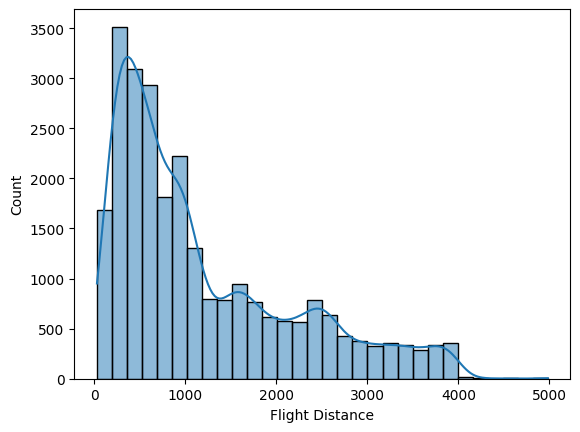

In [6]:
sns.histplot(df['Flight Distance'], bins=30, kde=True)
plt.show()

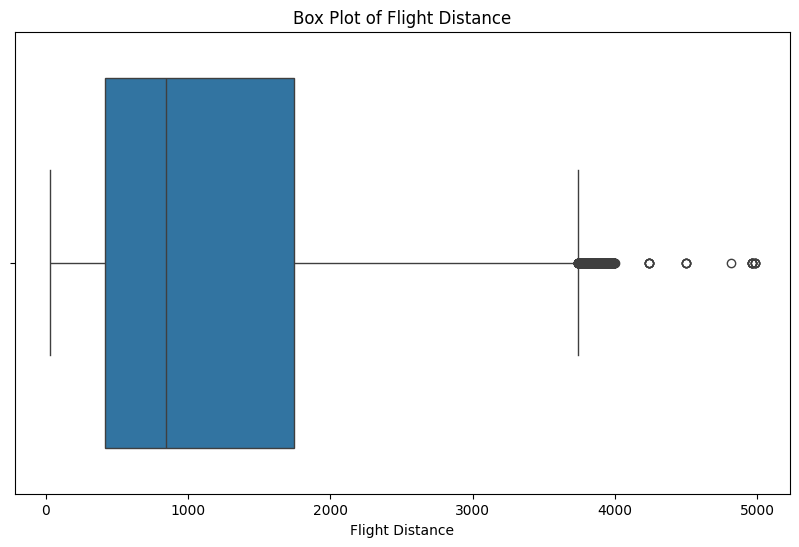

In [7]:
# see if we can remove noises (if not many)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Flight Distance'])
plt.title('Box Plot of Flight Distance')
plt.xlabel('Flight Distance')
plt.show()

In [8]:
df.drop(columns=['Flight Distance'], inplace=True)

In [15]:
label_probabilities = dict()
def fit(dataset: pd.DataFrame, target_attribute: str):
    for label in dataset[target_attribute].unique():
        label_probabilities[label] = len(dataset[dataset[target_attribute] == label]) / len(dataset)

In [16]:
def get_label_probability(input: pd.Series, label: str, dataset: pd.DataFrame, target_attribute: str):
    result = 1
    for attribute in dataset.columns:
        if attribute == 'satisfaction':
            continue
        if dataset[attribute].dtype.name == 'object': # if attribute is categorical
            result *= (len([index for index, row in dataset.iterrows() if row[target_attribute] == label and row[attribute] == input[attribute]])
                      / len([index for index, row in dataset.iterrows() if row[target_attribute] == label]))
        else: # numerical attribute
            attribute_series = dataset.loc[dataset[target_attribute] == label, attribute]
            attribute_mean = attribute_series.mean()
            attribute_std = attribute_series.std(ddof=0)  # Use population std deviation
            if attribute_std == 0:  # Handle edge cases where variance is zero
                likelihood = 1 if input[attribute] == attribute_mean else 0
            else:
                likelihood = (1 / (math.sqrt(2 * math.pi) * attribute_std)) * math.exp(- ((input[attribute] - attribute_mean) ** 2) / (2 * (attribute_std ** 2)))
            result *= likelihood    
    prior_probability = label_probabilities[label]
    result *= prior_probability
    
    return result

In [17]:
def predict(input: pd.Series, dataset: pd.DataFrame, target_attribute: str):
    max_probability_class = (0, '')
    for label in df[target_attribute].unique():
        label_probability = get_label_probability(input, label, dataset, target_attribute)
        if label_probability > max_probability_class[0]:
            max_probability_class = (label_probability, label)
    return max_probability_class[1]
        

In [25]:
train_data = df[:int(len(df) * .8)]
test_data = df[int(len(df) * .8):]

fit(train_data, 'satisfaction')

random_test_data = random.choices(test_data.index, k=5)

for index in random_test_data:
    predicted_label = predict(test_data.loc[index], train_data, "satisfaction")
    print(f'Predicted: {predicted_label}, Actual: {test_data.loc[index]["satisfaction"]}')

Predicted: neutral or dissatisfied, Actual: satisfied
Predicted: satisfied, Actual: satisfied
Predicted: satisfied, Actual: satisfied
Predicted: satisfied, Actual: satisfied
Predicted: neutral or dissatisfied, Actual: neutral or dissatisfied
